In [1]:
import os
import random
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import color

def load_patches_from_folder(folder_path):

    patches = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            img = cv2.imread(os.path.join(folder_path, filename))
            if img is not None:
                patches.append(img)
    return patches

def generate_background_from_patches(background_patches, num_patches=8, output_size=(256, 256)):

    selected_patches = random.choices(background_patches, k=num_patches)
    background = np.zeros((output_size[0], output_size[1], 3), dtype=np.uint8)
    patch_size = 128

    for i in range(0, output_size[0], patch_size):
        for j in range(0, output_size[1], patch_size):
            if selected_patches:
                patch = selected_patches.pop()

                if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
                    patch = cv2.resize(patch, (patch_size, patch_size))

                try:
                    background[i:i+patch_size, j:j+patch_size] = patch
                except ValueError as e:
                    print(f"Ошибка при размещении патча: {e}")
                    continue
            else:
                break

    return background

def overlay_cells_on_background(background, cell_patches, num_cells=5):

    output = background.copy()
    for _ in range(num_cells):

        cell = random.choice(cell_patches)
        x = random.randint(0, background.shape[0] - cell.shape[0])
        y = random.randint(0, background.shape[1] - cell.shape[1])
        mask = np.zeros((cell.shape[0], cell.shape[1], 3), dtype=np.uint8)
        radius = min(cell.shape[0], cell.shape[1]) // 2
        cv2.circle(mask, (cell.shape[1] // 2, cell.shape[0] // 2), radius, (255, 255, 255), -1)
        mask = cv2.GaussianBlur(mask, (51, 51), 0)
        mask = mask.astype(np.float32) / 255.0

        for c in range(3):
            output[x:x+cell.shape[0], y:y+cell.shape[1], c] = (
                output[x:x+cell.shape[0], y:y+cell.shape[1], c] * (1 - mask[:, :, c]) +
                cell[:, :, c] * mask[:, :, c]
            )
    return output

patches_folder = 'content/patches'
background_folder = os.path.join(patches_folder, 'background')
cells_folder = os.path.join(patches_folder, 'cells')

background_patches = load_patches_from_folder(background_folder)
cell_patches = load_patches_from_folder(cells_folder)

Текстурные характеристики Тамура: {'contrast': np.float64(0.14430094182513478), 'directionality': np.float64(0.16863819008223635), 'coarseness': np.float64(0.843646719827091)}


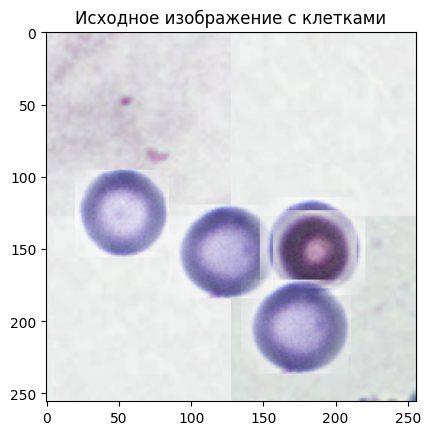

In [4]:
from skimage import color
def compute_tamura_features(img_data):
    gray_img = color.rgb2gray(img_data)

    contrast_value = np.std(gray_img)

    grad_h = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=3)
    grad_v = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = np.sqrt(grad_h**2 + grad_v**2)
    directionality_value = np.std(magnitude)

    coarseness_value = np.mean(gray_img)

    return {
        'contrast': contrast_value,
        'directionality': directionality_value,
        'coarseness': coarseness_value
    }

bg_image = generate_background_from_patches(background_patches)
result_img = overlay_cells_on_background(bg_image, cell_patches)

texture_features = compute_tamura_features(result_img)
print("Текстурные характеристики Тамура:", texture_features)

plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.title("Исходное изображение с клетками")
plt.show()

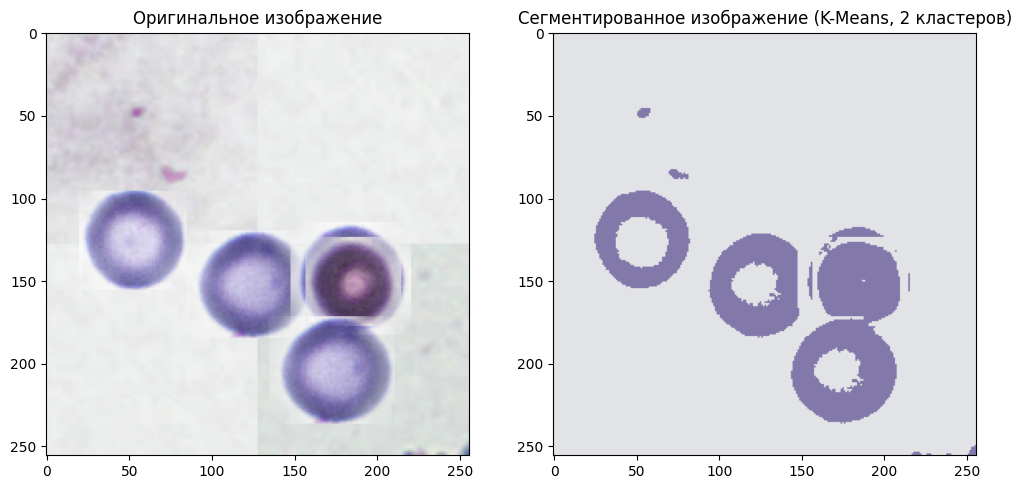

In [11]:
from sklearn.cluster import KMeans

def segment_image_kmeans(image, n_clusters=3):

    pixel_values = image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(pixel_values)

    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    centers = np.uint8(centers)

    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(image.shape)

    return segmented_image, labels.reshape(image.shape[:2])


n_clusters = 2
segmented_image, cluster_map = segment_image_kmeans(result_img, n_clusters=n_clusters)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.title("Оригинальное изображение")
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
plt.title(f"Сегментированное изображение (K-Means, {n_clusters} кластеров)")

plt.show()

In [12]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

def assess_segmentation_quality(img_data, cluster_map):
    pixels = img_data.reshape((-1, 3))

    silhouette = silhouette_score(pixels, cluster_map.flatten())
    db_index = davies_bouldin_score(pixels, cluster_map.flatten())

    return {
        'silhouette': silhouette,
        'db_index': db_index
    }

quality_metrics = assess_segmentation_quality(result_img, cluster_map)

print("Оценка качества сегментации:")
print(f"Silhouette Score: {quality_metrics['silhouette']:.4f}")
print(f"DB Index: {quality_metrics['db_index']:.4f}")

Оценка качества сегментации:
Silhouette Score: 0.8025
DB Index: 0.3902


Область 1:
  Площадь: 61261.0
  Периметр: 2099.3656197958435
  Эксцентриситет: 0.2006
  Компактность: 0.0139
  Угол ориентации: -0.7166
  Центр масс: (np.float64(125.17711104944418), np.float64(125.61931734708868))

Область 2:
  Площадь: 170.0
  Периметр: 48.2842712474619
  Эксцентриситет: 0.5165
  Компактность: 0.0729
  Угол ориентации: -0.6894
  Центр масс: (np.float64(151.39411764705883), np.float64(186.7058823529412))



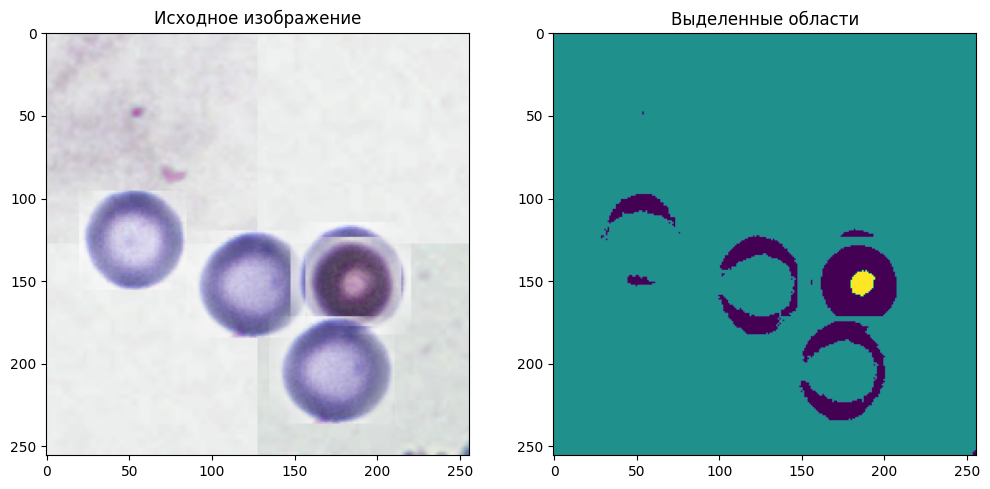

In [13]:
from skimage.measure import label, regionprops
from skimage import measure

def examine_objects(img_data):
    gray_img = cv2.cvtColor(img_data, cv2.COLOR_BGR2GRAY)
    _, binary_img = cv2.threshold(gray_img, 128, 255, cv2.THRESH_BINARY)
    labeled_img = label(binary_img)
    objects = regionprops(labeled_img)

    for idx, obj in enumerate(objects):
        print(f"Область {idx + 1}:")
        print(f"  Площадь: {obj.area}")
        print(f"  Периметр: {obj.perimeter}")
        print(f"  Эксцентриситет: {obj.eccentricity:.4f}")
        print(f"  Компактность: {(obj.area / (obj.perimeter ** 2)):.4f}")
        print(f"  Угол ориентации: {obj.orientation:.4f}")
        print(f"  Центр масс: {obj.centroid}")
        print()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB))
    plt.title("Исходное изображение")

    plt.subplot(1, 2, 2)
    plt.imshow(labeled_img, cmap='viridis')
    plt.title("Выделенные области")
    plt.show()

examine_objects(result_img)

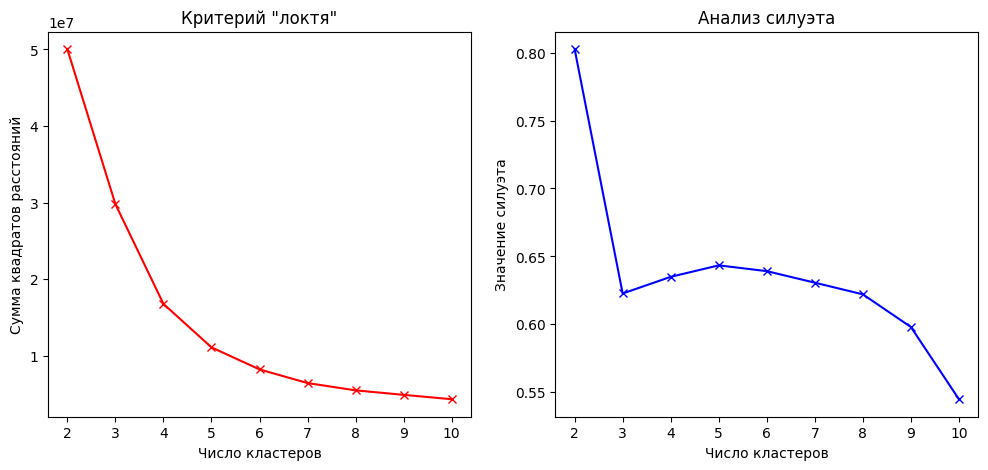

Рекомендуемое число кластеров: 2


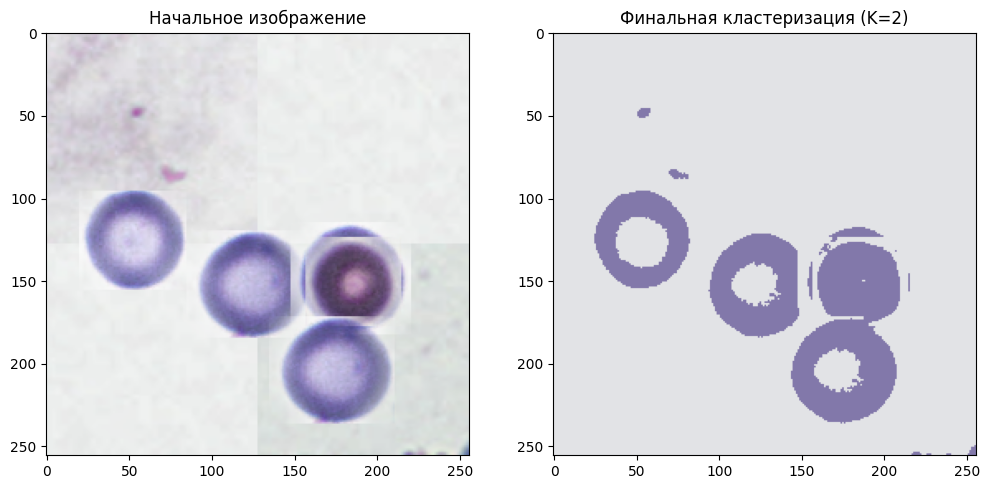

In [14]:
def determine_best_clusters(img_data, max_clusters=10):
    pixels = img_data.reshape((-1, 3))
    pixels = np.float32(pixels)

    inertia_values = []
    K_range = range(2, max_clusters + 1)
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(pixels)
        inertia_values.append(kmeans.inertia_)

    silhouette_values = []
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(pixels)
        silhouette_values.append(silhouette_score(pixels, labels))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(K_range, inertia_values, 'rx-')
    plt.xlabel('Число кластеров')
    plt.ylabel('Сумма квадратов расстояний')
    plt.title('Критерий "локтя"')

    plt.subplot(1, 2, 2)
    plt.plot(K_range, silhouette_values, 'bx-')
    plt.xlabel('Число кластеров')
    plt.ylabel('Значение силуэта')
    plt.title('Анализ силуэта')

    plt.show()

    best_k = K_range[np.argmax(silhouette_values)]
    print(f"Рекомендуемое число кластеров: {best_k}")

    return best_k

def perform_clustering(img_data, n_clusters):
    pixels = img_data.reshape((-1, 3))
    pixels = np.float32(pixels)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(pixels)
    cluster_centers = kmeans.cluster_centers_

    cluster_centers = np.uint8(cluster_centers)

    clustered_img = cluster_centers[cluster_labels.flatten()]
    clustered_img = clustered_img.reshape(img_data.shape)

    return clustered_img, cluster_labels.reshape(img_data.shape[:2])

optimal_k = determine_best_clusters(result_img, max_clusters=10)

final_result, final_labels = perform_clustering(result_img, optimal_k)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.title("Начальное изображение")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(final_result, cv2.COLOR_BGR2RGB))
plt.title(f"Финальная кластеризация (K={optimal_k})")

plt.show()